In [1]:
# ES control minimizing a quadratic function
# Dan Arnold, dbarnold@lbl.gov

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#ES function
#gets called every timestep

def es_function(t, T, hpf, lpf, f, c, a_param, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1):
    
    #outputs:
    #uk: the control to be applied at the next timestep
    #uhatk: the output of the integrator
    #gammak: the output of the lowpass filter
    #psik: signal after demodulation (mutliplication by cosine)
    #sigmak: the output of the washout (highpass) filter
    
    #inputs:
    #Jk, Jkm1: values of the objective function (metric we're optimizing) at the present and last timestep
    #sigmakm1: output of highpass filter at last timestep
    #psikm1: signal after demodulation at last timestep
    #gammakm1: output of lowpass filter 
    #uhatkm1: output of integrator at last timestep
    #t: present time at this timestep
    #T: distance between timesteps, delta_T
    #hpf: high pass filter gain, usually make this an order of magnitude lower than w
    #lpf: low pass filter gain, usually make this equal to hpf, but I usually end up adjusting this quite a bit
    #c: gain on the integrator - how much to value new measurements compared to old measurements
    #a_param: the amplitude of the probing signal

    #calculate angular frequency:
    w = 2*np.pi*f
    
    #print("J: ", Jk)

    #extract the effect of the probing signal in the objective function
    #do this by passing the signal through a highpass filter
    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)
    #print("sigma: ", sigmak)

    #the resulting signal is a sinusoid, multiply by a sinusoid of the same frequency
    #this results in a cos**2 term, that has a DC component (we call this demodulation)
    psik = sigmak*np.cos(w*t)
    #print("psi: ", psik)

    #pass the demodulated signal through a lowpass filter, to eliminate noise and "jumpiness"
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)
    #print("gamma: ", gammak)

    #pass the resulting signal through an integrator - this approximates a gradient descent
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    #modulation - add the perturbation to the next control setpoint
    uk = (uhatk + a_param*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk)

We can try to build some intuition as to why the method works.  Consider a quadratic objective function of the form:

\begin{align}
    J(u) = u^{2}
\end{align}

We seek to find the minimum of $J$ which is 0.  ES operates by approximating a gradient descent.  The gradient of this function is $2u$.  ES extracts this gradient by introducing a sinusoid into $u$, or

\begin{align}
    u = \hat{u} + a\cos \omega t
\end{align}

Where $\hat{u}$ is the quantity we want to drive to 0.  Note that $\hat{u}$ and $u$ have the same value on average (as the integral of a sinusoid over a period of the sinusoid is 0).  Here's what happens when we plug $u$ into $J$: 

\begin{align}
    J(\hat{u} + a\cos \omega t) = \hat{u}^{2} + 2a\hat{u} \cos \omega t + a^{2}\cos^{2} \omega t
\end{align}

Now $J$ has a DC term and a sinusoidal term.  To extract the gradient, we can multiply by $\cos \omega t$:

\begin{align}
    J(\hat{u} + a\cos \omega t)\cos \omega t = \hat{u}^{2}\cos \omega t + 2a\hat{u} \cos^{2} \omega t + a^{2}\cos^{3} \omega t
\end{align}

Recall now that $2\cos^{2} \omega t = 1 - \cos 2\omega t$.  So, even powers of sinusoids have DC components.  Let's expand:

\begin{align}
    J(\hat{u} + a\cos \omega t)\cos \omega t = \hat{u}^{2}\cos \omega t + a\hat{u} \left( 1 + \cos 2 \omega t\right) + \frac{a^{2}}{2}\left(1 - \cos 2\omega t\right)\cos \omega t
\end{align}

We can "average" the signal by integrating over a period of the sinusoid.  When we do this, the only term remaining is $\hat{u}_{av}$.  We're off by a factor of 2, but we can account for this by choice of gains.  The subscript "av" indicates that this gradient is being averaged over a period of the sinusoid.  Now that we've got the gradient, the only thing we need to do is pass this quantity through an integrator to get a gradient descent.  The high and lowpass filters are put in the loop to reduce the effect of noise.

program running
program complete


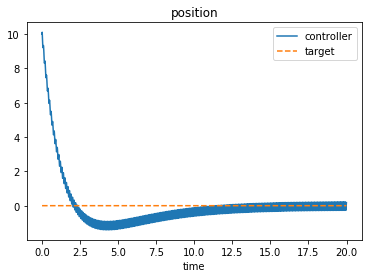

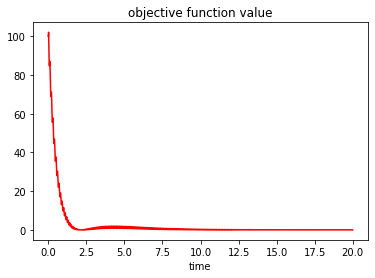

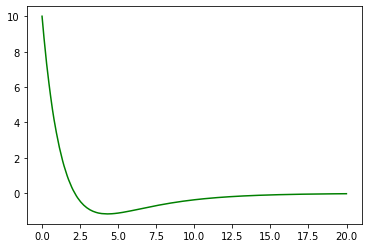

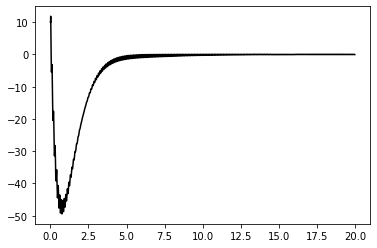

In [12]:
#Simulation

#Line search - the goal of this experiment is to minimize a quadratic function
#the initial value of the controller, u, is the starting position
#we want to drive this value to the minimum of the quadratic, or u=0

#setup time
T = 0.01 #delta T: the length of each timestep
time = np.arange(0.,2000.)
time = time*T

#setup vectors to store past values of the ES control
J = np.zeros(len(time)) #objective function
sigma = np.zeros(len(time)) #value after highpass (washout) filter
psi = np.zeros(len(time)) #value after demodulation
gamma = np.zeros(len(time)) #value after lowpass filter
uhat = np.zeros(len(time)) #value after integration
u = np.zeros(len(time))  #control outputs of ES control (position)

#initial conditions
u[0] = 10 #choosing an initial condition - in this case its a position at these many units away from the origin
u_target = 0
J[0] = (u[0] - u_target)**2
sigma[0] = u[0]
psi[0] = u[0]
gamma[0] = u[0]
uhat[0] = u[0]

#setup parameters for the ES controller
f = 10 #frequency of probe, in Hz
c = -1 #gain on the integrator
lpf = 1 #lowpass filter critical frequency
hpf = 1 #highpass filter critical frequency
a = 0.25 #amplitude of the probe

#J = np.append(J,1)
print("program running")

for i in range(0,len(time)):
    
    #don't do anything the first timestep
    
    if(i>=1):

        #evaluate objective function value
        #minimie a quadratic, minimum value is 0
        J[i] = (u[i-1] - u_target)**2 
        
        #call the ES controller
        uk, sigmak, psik, gammak, uhatk = es_function(time[i], T, hpf, lpf, f, c, a, J[i], J[i-1], \
            sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1])

        #store values for next timestep
        u[i] = uk
        sigma[i] = sigmak
        psi[i] = psik
        gamma[i] = gammak
        uhat[i] = uhatk
        #print("----------------------------")

print("program complete")

target = np.ones(len(u))*u_target;

#this is the output of the ES controller
fig1 = plt.figure(1)
plt.plot(time,u,label="controller")
plt.plot(time,target,'--',label="target")
plt.title('position')
plt.xlabel('time')
plt.legend()
fig1.savefig('ES_basic.png')

plt.figure(2)
plt.plot(time,J,'r')
plt.title('objective function value')
plt.xlabel('time')

plt.figure(3)
plt.plot(time,uhat,'g')

plt.figure(4)
plt.plot(time,sigma,'k')
